In [0]:
import pandas as pd
import csv
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [0]:
def read_file(filename):
  #파일 불러오기
  df = pd.read_csv(filename, encoding='cp949')
  
  #전처리과정
  df = df.rename(columns={'field1':'temperature'})
  df = df.rename(columns={'field2':'humidity'})
  df = df.rename(columns={'field3':'co2'})
  df = df.rename(columns={'field4':'pm1'})
  df = df.rename(columns={'field5':'pm2.5'})
  df = df.rename(columns={'field6':'pm10'})
  df = df.drop('entry_id', axis=1)
  df = df.iloc[:, :7]
  
  df = df.replace("-", np.nan)
  df = df.dropna(axis=0)
  df.iloc[:,1:] = df.iloc[:,1:].astype(str).astype(float)
  for i in range(1, len(df)):
      if (df.iloc[i,4]>df.iloc[i-1,4]+20) or (df.iloc[i, 4] > 200):
        df.iloc[i, 4]=df.iloc[i-1, 4]
      if (df.iloc[i,5]>df.iloc[i-1,5]+20) or (df.iloc[i, 5] > 200):
        df.iloc[i, 5]=df.iloc[i-1, 5]
      if (df.iloc[i,6]>df.iloc[i-1,6]+20) or (df.iloc[i, 6] > 200):
        df.iloc[i, 6]=df.iloc[i-1, 6]
      df.iloc[i-1,0] = df.iloc[i-1,0][:13]
  df['created_at'] = pd.to_datetime(df['created_at'])
  df = df.set_index('created_at', inplace=False)
  df = df.groupby("created_at").mean()

  return df

In [0]:
#input : train, test용 데이터, 예측할 갯수 -  pandas.Series 형
#output : 
sc = MinMaxScaler()

def data_transfer(train, test):
  #0과 1사이로 스케일링

  train_sc = sc.fit_transform(pd.DataFrame(train))
  test_sc = sc.fit_transform(pd.DataFrame(test))

  train_sc_df = pd.DataFrame(train_sc, columns=['Scaled'], index=train.index)
  test_sc_df = pd.DataFrame(test_sc, columns=['Scaled'], index=test.index)
  
  #과거의 값을 shift시킴. 과거값 shift1~ 를 통해 현재값 scaled를 예측하는 것


  for s in range(1, 13):
      train_sc_df['shift_{}'.format(s)] = train_sc_df['Scaled'].shift(s)
      test_sc_df['shift_{}'.format(s)] = test_sc_df['Scaled'].shift(s)

  train_sc_df.head(13)
  
  #x값 = 과거의 값. y값 = 예측하려는 현재의 값(scaled)

  X_train = train_sc_df.dropna().drop('Scaled', axis=1)
  y_train = train_sc_df.dropna()[['Scaled']]

  X_test = test_sc_df.fillna(0).drop('Scaled', axis=1)
  y_test = test_sc_df.fillna(0)[['Scaled']]
  
  X_train = X_train.values
  X_test= X_test.values

  y_train = y_train.values
  y_test = y_test.values
  
  X_train_t = X_train.reshape(X_train.shape[0], 12, 1)
  X_test_t = X_test.reshape(X_test.shape[0], 12, 1)


  print("최종 DATA")
  #size, timestep, feature --> keras lstm input shape
  print(X_train_t.shape)

  return X_train_t, y_train, X_test_t, y_test

In [0]:
def lstm_predict(X_train, y_train, X_test):
  K.clear_session()
  model = Sequential() # Sequeatial Model
  model.add(LSTM(20, input_shape=(12, 1))) 
  # (timestep, feature) 
  model.add(Dense(1)) 
  # output = 1 
  model.compile(loss='mean_squared_error', optimizer='adam') 
  model.summary()
  early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)
  model.fit(X_train, y_train, epochs=50, batch_size=30, verbose=1, callbacks=[early_stop])
  y_pred = model.predict(X_test)
  
  return y_pred

In [0]:
from keras.layers import LSTM 
from keras.models import Sequential 
from keras.layers import Dense 
import keras.backend as K
from keras.callbacks import EarlyStopping 

Using TensorFlow backend.


In [0]:
df = read_file('301.csv')
#이 기간만 사용할 것
df2 = df.loc['2019-05-31 1:00' :]

#train 데이터와 test데이터를 나눔. pm10예측
#6월 4-5일 값 예측 (12시간)
train2 = df2.iloc[:,5] #pm10
test2 = df2.iloc[:,5]
train2 = train2.loc[:'2019-06-03 23']
test2 = test2.loc['2019-06-04 00':'2019-06-04 23']

X_train_t, y_train, X_test_t, y_test = data_transfer(train2, test2)
#모델 에측값 y_pred
y_pred = lstm_predict(X_train_t, y_train, X_test_t)
#0~1사이인 y_pred를 실제 값으로 변환
y_pred_real = sc.inverse_transform(y_pred)
y_pred_real = y_pred_real.reshape(-1, )
#그래프를 위한 작업
y_pred_real = pd.DataFrame(y_pred_real, index=test2.index)
y_pred_real.columns = ['predict']

W0803 18:21:32.221523 140151043979136 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0803 18:21:32.222377 140151043979136 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0803 18:21:32.239260 140151043979136 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0803 18:21:32.240665 140151043979136 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W080

최종 DATA
(66, 12, 1)


W0803 18:21:32.595688 140151043979136 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 20)                1760      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
Total params: 1,781
Trainable params: 1,781
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
66/66 [==============================] - 1s 22ms/step - loss: 0.3975
Epoch 2/50
66/66 [==============================] - 0s 857us/step - loss: 0.3375
Epoch 3/50
66/66 [==============================] - 0s 863us/step - loss: 0.2837
Epoch 4/50
66/66 [==============================] - 0s 875us/step - loss: 0.2375
Epoch 5/50
66/66 [==============================] - 0s 890us/step - loss: 0.1961
Epoch 6/50
66/66 [==============================] - 0s 1ms/step - loss: 0.1605
Epoch 7/50
66/66 [==============================] - 0

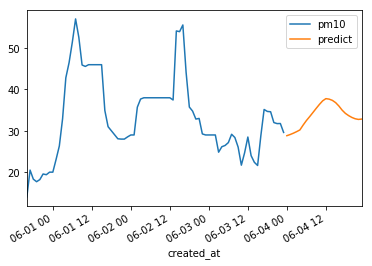

In [0]:
#예측값과 이전의 실제 값 붙임
pd.concat([train2, y_pred_real], axis=1).plot()

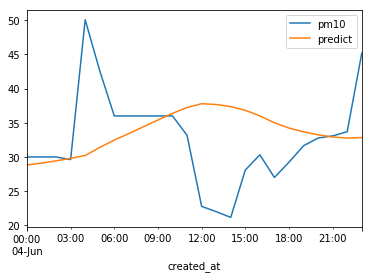

In [0]:
#예측값과 실제 값 비교
pd.concat([test2, y_pred_real], axis=1).plot()

ARIMA 랑 그래프가 비슷한 것을 볼 수 있음

In [0]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [0]:
rmse = sqrt(mean_squared_error(test2, y_pred_real))
print('Test RMSE : %.3f' %rmse)

n = train2.shape[0]
d = np.abs(np.diff(train2, axis=0)).sum()/(n-1)
test2 = pd.DataFrame(test2)
err = np.abs(test2['pm10'] - y_pred_real['predict'])
mase = err.mean()/d
print('Test MASE : ', mase)

Test RMSE : 8.295
Test MASE :  2.3916282754309797
